# Gromos Tutorial
This tutorial will provide a quick introduction to how to setup, perform and analyze a MD simulation of a peptide in Gromos.

First we will generated the required input files, afterwards the simulation will be prepared with energy minimizations and equilibration.
Finally a short MD simulation will be executed and quickly analyzed.

But first some minor definitions will be prepared.

In [1]:
import os
# Check if the path to this pacakge is set, else try to add it.
try:
    import pygromos
except:
    import os, sys, copy
    root_dir = os.getcwd()
    sys.path.append(root_dir+"/..")

    #if package is not installed and path not set correct - this helps you out :)
    import pygromos

from pygromos.utils import bash


In [2]:
#General path definitions:
## Project dir - The project dir will contain  all files and results generated from this notebook. 
project_dir = os.path.abspath("example_files/Tutorial_System")
input_dir = project_dir+"/input" # contains prepared files (pdb of the peptide)

## Gromos Bin Path
gromosXX_bin = None
gromosPP_bin = None #None uses the Path variable - can be used . if you require a specific compiled gromos version, add a path here.



## Build the input files
When a simulation study of a particular system or process is to be carried out, a number of choices have to
be made with respect to the set-up of the simulation. 

In PyGromosTools, the central hub to manage all these files is a GromosSystem object. Each file can be stored or generated with this object and it can be used to construct the system, that should be simulated.


The essential files of a Simulation are:
* a topology file, containing all the topological and force-field information of the molecular system to be studied.
* a coordinate file, representing the system of interest.
* a simulation parameter file, telling the simulation engine, which simulation technique should be used and which physical parameters should be set.
  


In [3]:
from pygromos.files.gromos_system import Gromos_System

# Build Gromos System object
build_system = Gromos_System(work_folder=project_dir, system_name='peptide')

#set file building folder
build_system.work_folder = bash.make_folder(project_dir+"/a_build_initial_files")


/home/mlehner/PyGromosTools/pygromos/files/gromos_system/gromos_system.py:869: UserWarning: Did not change file path as its only promised None
  warnings.warn("Did not change file path as its only promised " + str(file_obj.path))


**Expert Tip**:
Whenever you wonder about what a class or a function in our package does, you can use the standard help function of Python to get the information of the Docstring of the source code! This often helps understanding the code.

In [4]:
help(build_system)

Help on Gromos_System in module pygromos.files.gromos_system.gromos_system object:

class Gromos_System(builtins.object)
 |  Gromos_System(work_folder: str, system_name: str, rdkitMol: rdkit.Chem.rdchem.Mol = None, in_mol2_file: str = None, readIn: bool = True, forcefield: pygromos.files.forcefield._generic_force_field._generic_force_field = <pygromos.files.forcefield._generic_force_field._generic_force_field object at 0x7f799f5a9460>, auto_convert: bool = False, adapt_imd_automatically: bool = True, verbose: bool = False, in_smiles: str = None, in_residue_list: List = None, in_top_path: str = None, in_cnf_path: str = None, in_imd_path: str = None, in_disres_path: str = None, in_ptp_path: str = None, in_posres_path: str = None, in_refpos_path: str = None, in_qmmm_path: str = None, in_gromosXX_bin_dir: str = None, in_gromosPP_bin_dir: str = None)
 |  
 |  Methods defined here:
 |  
 |  __deepcopy__(self, memo)
 |  
 |  __getstate__(self)
 |      preperation for pickling:
 |      remove 

### The Topology File
The first task is to generate a molecular topology file containing the topological and force-field data concerning the molecular system under consideration. Specifying a complete molecular topology for a large molecule, however, is a tedious task.
Therefore, in GROMOS a molecular topology is generated from molecular topology building blocks which carry the topological
information of molecules like amino acid residues, nucleotides, etc., see Vol. 3. The molecular topology building blocks can be linked together into a complete molecular topology file using the GROMOS++ program *make_top*.

Many molecular topology building blocks are available in the molecular topology building block files (*\*.mtb*), which are standard data files that come together with the GROMOS package. 


In case the needed molecular topology building blocks are not part of the standard distribution, they must be constructed. 
Constructing a new topology building block may require estimation of additional force-field parameters, which have to be added to the interaction function parameter file (*\*.ifp*).
 
When generating a molecular topology for the system of interest one should also address the protonation state of the molecular groups according to the pH and of the solvent and counter ions that need to be included in the simulation box. 
In case of a molecular complex, e.g. a DNA-protein complex, the two separately generated molecular topologies for the protein and the DNA can be merged using the GROMOS++ program com top.



#### Building the Topology File
In this section you should build a molecular topology of a linear charged penta-peptide with water as a solvent, including two Cl− counter ions.

**programs: make_top, check_top**

##### build topology for single molecule
You will build the molecular topology file of the linear charged penta-peptide Val-Tyr-Arg-Lys-Gln by
using the GROMOS++ program *make_top*. As input following parameters will be provided:
* **in_building_block_lib_path**: the molecular topology building block file is specified. In the code below, you will see, that we gather the forcefield information from the *Gromos54A7* force field, which is directly provided by PyGromosTools
* **in_parameter_lib_path**: specifies the interaction function parameter file. Also here we take the parameters directly from the *Gromos54A7* forcefield from PyGromosTools.
* **in_solvent**: The string name of the desired solvent.
* **in_sequence**: the sequence of the building blocks for the amino acid residues, including the amino and carboxy terminus
is specified (*NH3+ VAL TYR ARG LYSH GLN COO-*). (Notice that both termini are charged)

In [5]:
from pygromos.data.ff import Gromos54A7 #Get standard information of the GROMOS54A7 force field.

#Generate the topology
build_system.make_top(in_sequence="NH3+ VAL TYR ARG LYSH GLN COO-",
                     in_solvent="H2O",
                     in_building_block_lib_path = Gromos54A7.mtb,
                     in_parameter_lib_path= Gromos54A7.ifp)

#Here the residues in the topology file will be printed out :)  - this corresponds to the RESNAME Block in the topology file:
build_system.top.RESNAME

RESNAME
5
VAL
TYR
ARG
LYSH
GLN
END

### The Coordinate File
Coordinates for biomolecules are often available from X-ray or NMR experiments and can be obtained in
*Protein Data Bank* (*PDB*) format, which can be converted to *GROMOS* format using the GROMOS++
program *pdb2g96*. However, the conversion is not always straightforward since the naming and numbering
of the atoms in the *PDB* format usually do not match the *GROMOS* format. 

Moreover, the coordinates for hydrogen atoms are not present in the *PDB* files 
(when the structure was determined using X-ray diffraction data) and have to be generated using the GROMOS++ program *gch*.

When the structure is determined using NMR data, the PDB structure often contains more hydrogen atoms than are needed for GROMOS,
as in the GROMOS force field only polar and aromatic hydrogens are explicitly represented. Aliphatic
hydrogens are non-existing due to the use of so-called united atoms. The aliphatic hydrogen and carbon
atoms are merged to form united atoms which have their own parameters. If no atomic coordinates for the
solute are available from experimental data, the coordinates have to be generated using molecular modeling
software. Often parts of the structure (e.g. flexible loops) are not resolved in the experiment and therefore
not available in the PDB and have to be modeled as well. 

#### Periodic Boxes
When a simulation of a solute in solution is to be carried out, a (periodic) box (be it rectangular, triclinic or truncated octahedral) is put around the solute
and filled with solvent molecules up to the required density. The solvent coordinates can e.g. be generated using the GROMOS++ program sim box. The generated box should be sufficiently large to allow the use of a reasonable non-bonded interaction cut-off radius. Putting the solute in a box of solvent using the *sim_box* program will result in several high-energy atom-atom contacts at the solute-solvent interface and at the box edges. In order to relax the generated configuration the solvent configuration should be energy minimized while positionally restraining the solute. Counter-ion atomic coordinates can then be generated using the GROMOS++ program *ion*, which can replace a number of solvent molecules by ions.

**programs: pdb2g96, gch**


#### Building the Coordinate File
The initial coordinate *.pdb* file is already provided in the *input* directory as *peptide.pdb*. 
Open the file *peptide.pdb* and check if the atom names match the names in the molecular topology object **SOLUTEATOM** block.
In the pdb file *peptide.pdb* the coordinates for hydrogen atoms are not given and have to be generated.
If the atom names are correct, you can continue in the second next cell by converting the *PDB* file *peptide.pdb* into the GROMOS format using the GROMOS++ program *pdb2g96*.
The hydrogen atoms will be added to the coordinate file according to the topological requirements.

***
**Warning**: When converting coordinate files from the Protein Data Bank to GROMOS format many difficulties may emerge. If you encounter problems using the pdb2g96 program, have a look at Sec. 4-7.3. There you can find further documentation on the advanced usage of this program. Especially the use of a library
that matches residue and atom names might be useful in many cases. pdb2g96.lib which you can find in the directory is an example of the PDB library file.
***


In [6]:
#Compare the atom names of the pdb file input/peptide.pdb with the printed ones here:
build_system.top.SOLUTEATOM

SOLUTEATOM
#   NRP: number of solute atoms
 	 71
#  ATNM: atom number
#  MRES: residue number
#  PANM: atom name of solute atom
#   IAC: integer (van der Waals) atom type code
#  MASS: mass of solute atom
#    CG: charge of solute atom
#   CGC: charge group code (0 or 1)
#   INE: number of excluded atoms
# INE14: number of 1-4 interactions
# ATNM MRES PANM IAC     MASS       CG  CGC INE
#                                           INE14
	1	1	H1	21	1.008	0.248	0	4	2	3	4	5
										2	6	9
	2	1	H2	21	1.008	0.248	0	3	3	4	5
										2	6	9
	3	1	N	8	14.0067	0.129	0	4	4	5	6	9
										4	7	8	10	11
	4	1	H3	21	1.008	0.248	0	1	5
										2	6	9
	5	1	CA	14	13.019	0.127	1	6	6	7	8	9	10	11
										2	12	13
	6	1	CB	14	13.019	0.0	0	3	7	8	9
										2	10	11
	7	1	CG1	16	15.035	0.0	0	1	8
										1	9
	8	1	CG2	16	15.035	0.0	1	0
										1	9
	9	1	C	12	12.011	0.45	0	4	10	11	12	13
										2	14	27
	10	1	O	1	15.9994	-0.45	1	1	11
										2	12	13
	11	2	N	6	14.0067	-0.31	0	4	12	13	14	27
										3	15	28	2

In [7]:
# Generate coordinate file:
build_system.pdb2gromos(in_pdb_path=input_dir+"/peptide.pdb")

#show the coordinates that were generated.
build_system.cnf.view

NGLWidget()

##### Initial Write out
 Next we will write out all generated files, such we have the initial products of our efforts.

In [8]:
# Now write all files, such that you can check them directly.
print("Path before rebase: "+str(build_system.cnf.path))
build_system.rebase_files()

#check this 
print("Path after rebase: "+build_system.cnf.path)

#Check also how the system path and attributes were automatically updated.
build_system


Path before rebase: None
File imd is empty , can not be written!
Path after rebase: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/a_build_initial_files/peptide.cnf



GROMOS SYSTEM: peptide
################################################################################
WORKDIR: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/a_build_initial_files
LAST CHECKPOINT: None

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: None
	top: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/a_build_initial_files/peptide.top
	cnf: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/a_build_initial_files/peptide.cnf
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	[]  resID: []  natoms: 0
	Non-LIGANDS:	[]  nmolecules: 0  natoms: 0
	SOLVENT:	[]  nmolecules: 0  natoms: 0



#### add hydrogens
Have a look at the cnf coordinates in the GromosSystem (next cell). You will notice that the hydrogen atoms have been added
to the coordinate file with the Cartesian coordinates being set to zero. 


In [9]:
#print x lines of the Position Block of valine
print("".join([str(atomP) for atomP in build_system.cnf.POSITION if("VAL" == atomP.resName)]))

    1 VAL   H1         1    0.000000000    0.000000000    0.000000000
    1 VAL   H2         2    0.000000000    0.000000000    0.000000000
    1 VAL   N          3    1.196200000    1.413300000    1.529800000
    1 VAL   H3         4    0.000000000    0.000000000    0.000000000
    1 VAL   CA         5    1.237300000    1.322400000    1.421900000
    1 VAL   CB         6    1.116100000    1.268700000    1.345400000
    1 VAL   CG1        7    1.041700000    1.369500000    1.257600000
    1 VAL   CG2        8    1.157800000    1.148100000    1.261100000
    1 VAL   C          9    1.335700000    1.393300000    1.328600000
    1 VAL   O         10    1.447800000    1.344200000    1.316600000




In order to generate meaningful coordinates for the hydrogen atoms run the GROMOS++ program *protonate* (or gch). It will generate the coordinates
for hydrogen atoms by geometric means using the information from the molecular topology file.
The argument *tolerance* sets the tolerance that is used for keeping the coordinates of hydrogens that are already present in the coordinate file.


In [10]:
# Add the hydrogen positions
build_system.add_hydrogens()

#store the current files with a different name:
build_system.name = "peptideH"
build_system.rebase_files()

#visualize again the nice structure
build_system.cnf.view


File imd is empty , can not be written!


NGLWidget()

#### Optional: Convert cnf to pdb



In [11]:
pdb_path = build_system.cnf.write_pdb(build_system.work_folder+"/vacuum_hpeptide.pdb")
pdb_path

'/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/a_build_initial_files/vacuum_hpeptide.pdb'

### Energy Minimization - Vacuum

Before putting the penta-peptide into a box of solvent, its configuration can be relaxed by energy minimisation.

#### Simulation Parameter File
The GROMOS simulation parameter file (also called imd) template_emin_vac can be parsed like follows and contains the following blocks:

In [12]:
from pygromos.data.simulation_parameters_templates import  template_emin_vac

#load simulation parameter file (Imd) File
build_system.imd = template_emin_vac

#for nicer code we will store the simulation parameter file in a variable.
emin_vac_imd_file = build_system.imd


##### TITLE Block
In the TITLE block you specify what is done with following input file, so you know what you did with it later and can easily reuse it.

In [13]:
emin_vac_imd_file.TITLE

TITLE
	steepest descent energy minimization of the peptide in vacuum

	>>> Generated with PyGromosTools (riniker group) <<<
END

##### ENERGYMIN Block

The existence of the ENERGYMIN block means that Gromos will perform an energy minimisation
(EM) run. The NTEM switch indicates which minimisation algorithm to be used. With NTEM = 1 we indicate
that the steepest-descent algorithm (Sec. 2-11.2) is used. NCYC gives the number of steps before resetting of
conjugate-gradient search direction in case we would use the conjugate gradient method (NTEM = 2). Using
DELE the energy threshold (the difference in energy between two energy minimisation steps) for stopping the
minimisation process (convergence) is specified. The initial step size and maximum step size is given in DX0
and DXM, respectively. Using FLIM the absolute value of the forces can be limited to a maximum value before
the algorithm is applied (see also 4-93).

In [14]:
help(emin_vac_imd_file.ENERGYMIN)

Help on ENERGYMIN in module pygromos.files.blocks.imd_blocks object:

class ENERGYMIN(_generic_imd_block)
 |  ENERGYMIN(NTEM: int = 0, NCYC: int = 0, DELE: float = 0, DX0: float = 0, DXM: float = 0, NMIN: int = 0, FLIM: float = 0, content: List[str] = None)
 |  
 |  ENERGYMIN block
 |  This block takes care of managing the Energyminimization controls.
 |  
 |  Attributes
 |  ----------
 |  NTEM:   int
 |      controls energy minimisation mode.
 |      0: do not do energy minimisation (default)
 |      1: steepest-descent minimisation
 |      2: Fletcher-Reeves conjugate-gradient minimisation
 |      3: Polak-Ribiere conjugate-gradient minimisation
 |  NCYC:   int
 |      >0 number of steps before resetting the conjugate-gradient search direction
 |      =0 reset only if the energy grows in the search direction
 |  DELE:   float
 |      >0.0 energy threshold for convergence
 |      >0.0 (conjugate-gradient) RMS force threshold for convergence
 |  DX0:    float
 |      >0.0 initial step 

In [15]:
# The current ENERGYMIN Block
emin_vac_imd_file.ENERGYMIN

ENERGYMIN
# 	 NTEM 	 NCYC 	 DELE 	 DX0 	 DXM 	 NMIN 	 FLIM
 	 1 	 0 	 0.100000 	 0.010000 	 0.050000 	 2000 	 0.000000 	 
END

##### SYSTEM Block
In the SYSTEM block you specify the number of solutes (NPM) and solvent (NSM) molecules. You only have
one solute NPM = 1 and no solvent molecules NSM = 0 because you still did not add any solvent molecules
to the configuration file and the peptide is still in vacuum. Otherwise you would have to tell MD++ how
many solvent molecules you are using.

In [16]:
help(emin_vac_imd_file.SYSTEM)

Help on SYSTEM in module pygromos.files.blocks.imd_blocks object:

class SYSTEM(_generic_imd_block)
 |  SYSTEM(NPM: int = 0, NSM: int = 0, content: List[str] = None)
 |  
 |  System Block
 |  
 |      The system block defines the number of solute molecules and solvent molecules
 |  
 |  Attributes
 |  ----------
 |  NPM:    int
 |      Number of Solute Molecules
 |  NSM:    int
 |      Number of Solvent Molecules
 |  
 |  Method resolution order:
 |      SYSTEM
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NPM: int = 0, NSM: int = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'NPM': <class 'int'>, 'NSM': <class 'int'>, 'name':...
 |  
 |  name = 'SYSTEM'
 |

In [17]:
emin_vac_imd_file.SYSTEM


SYSTEM
# 	 NPM 	 NSM
 	 1 	 0 	 
END

##### STEP Block

The step block takes core of how long and with 

In [18]:
help(emin_vac_imd_file.STEP)

Help on STEP in module pygromos.files.blocks.imd_blocks object:

class STEP(_generic_imd_block)
 |  STEP(NSTLIM: int = 0, T: float = 0, DT: float = 0, content: List[str] = None)
 |  
 |  Step Block
 |  
 |      This Block gives the number of simulation steps,
 |  
 |  Attributes
 |  -----------
 |  NSTLIM: int
 |      number of simulations Step till terminating.
 |  T:  float
 |      Starting Time
 |  DT: float
 |      time step [fs]
 |  
 |  Method resolution order:
 |      STEP
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NSTLIM: int = 0, T: float = 0, DT: float = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'DT': <class 'float'>, 'NSTLIM': <class 'int'

In [19]:
emin_vac_imd_file.STEP

STEP
# 	 NSTLIM 	 T 	 DT
 	 3000 	 0.000000 	 0.002000 	 
END

In the BOUNDCOND block you specify which periodic boundary conditions (PBC) you are going to use in the
EM procedure. NTB = 0 defines a vacuum simulation: PBC are not applied. To indicate the truncated
octahedron (t) PBC, NTB is set to -1, for rectangular (r) PBC NTB is 1, and for the triclinic (c) PBC NTB is
2. NDFMIN defines the number of degrees of freedom subtracted from the total number of degrees of freedom
for the calculation of the temperature.


In [20]:
help(emin_vac_imd_file.BOUNDCOND)

Help on BOUNDCOND in module pygromos.files.blocks.imd_blocks object:

class BOUNDCOND(_generic_imd_block)
 |  BOUNDCOND(NTB: int = 0, NDFMIN: int = 0, content: List[str] = None)
 |  
 |  Boundary Condition Block
 |  
 |      This block describes the boundary condition of the coordinate system.
 |  
 |  Attributes
 |  ----------
 |      NTB : int, optional
 |          Boundary conditions, by default 0
 |          -1 : truncated octahedral
 |           0 : vacuum
 |           1 : rectangular
 |           2 : triclinic
 |      NDFMIN : int, optional
 |          number of degrees of freedom subtracted for temperature, by default 0
 |  
 |  Method resolution order:
 |      BOUNDCOND
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NTB: int = 0, NDFMIN: int = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  -

In [21]:
emin_vac_imd_file.BOUNDCOND

BOUNDCOND
# 	 NTB 	 NDFMIN
 	 0 	 0 	 
END

With the PRINTOUT block you can specify how often (every NTPRth step) you are printing out the energies
to the output file.

In [22]:
help(emin_vac_imd_file.PRINTOUT)

Help on PRINTOUT in module pygromos.files.blocks.imd_blocks object:

class PRINTOUT(_generic_imd_block)
 |  PRINTOUT(NTPR: int = 0, NTPP: int = 0, content: List[str] = None)
 |  
 |  PRINTOUT block
 |  
 |      This Block manages the output frequency into the .omd/std-out file.
 |  
 |  Attributes
 |  ----------
 |  NTPR: int
 |      print out energies, etc. every NTPR steps
 |  NTPP: int
 |      =1 perform dihedral angle transition monitoring
 |  
 |  Method resolution order:
 |      PRINTOUT
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NTPR: int = 0, NTPP: int = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'NTPP': <class 'int'>, 'NTPR': <class 'int'>, '

In [23]:
emin_vac_imd_file.PRINTOUT

PRINTOUT
# 	 NTPR 	 NTPP
 	 10 	 0 	 
END

Bonds vibrate at high frequencies (hν ≫ kBT ). Therefore, these vibrations are of quantum-mechanical
nature. So constraining the bond lengths is a better approximation than treating them as classical harmonic
oscillators. Constraining all bond lengths of the solute and solvent (NTC=3) allows the use of a rather large
time step of 2 fs. In this example the constraints are imposed by the SHAKE algorithm for both solute
(NTCP=1) and solvent (NTCS=1) with a tolerance of 0.0001. See 4-90 for more information.

In [24]:
help(emin_vac_imd_file.CONSTRAINT)

Help on CONSTRAINT in module pygromos.files.blocks.imd_blocks object:

class CONSTRAINT(_generic_imd_block)
 |  CONSTRAINT(NTC: int = 0, NTCP: int = 0, NTCP0: float = 0, NTCS: int = 0, NTCS0: float = 0, content: List[str] = None)
 |  
 |  CONSTRAINT block
 |      This block is controlling constraining the atoms during a simulation.
 |  
 |  Attributes
 |  ----------
 |  NTC:    int
 |  NTCP:   int
 |  NTCP0:  int
 |  NTCS:   int
 |  NTCS0:  int
 |  
 |  Method resolution order:
 |      CONSTRAINT
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NTC: int = 0, NTCP: int = 0, NTCP0: float = 0, NTCS: int = 0, NTCS0: float = 0, content: List[str] = None)
 |      Args:
 |          NTC:
 |          NTCP:
 |          NTCP0:
 |          NTCS:
 |          NTCS0:
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes de

In [25]:
emin_vac_imd_file.CONSTRAINT

CONSTRAINT
# 	 NTC
 	 3 	 
# 	 NTCP 	 NTCP0(1)
 	 1 	 0.000100 	 
# 	 NTCS 	 NTCS0(1)
 	 1 	 0.000100 	 
END

In the FORCE block you tell MD++ which terms it should use for the energy and force calculation. For bond
angles, improper dihedrals, torsional dihedrals and the non-bonded interactions the standard terms of the
GROMOS force field are switched on (1). Because we are using bond-length constraints and the SHAKE
algorithm, we have to switch off (0) the bond-stretching terms for the bonds involving hydrogen atoms and
not involving hydrogen atoms..
In the last line of this block, the energy groups are defined. In general, we define one or more energy
groups for every molecule, and one comprising all the solvent molecules. The first integer is the number of
energy groups we want to use (in the present case we only have one energy group). The following numbers
are the atom sequence numbers of the last atom of each energy group. By defining these energy groups we
7-9
tell MD++ to sum up the energies between the atoms within these groups and calculate the inter-group
energies, which can be very useful.

In [26]:
emin_vac_imd_file.FORCE

FORCE
# 	 BONDS 	 ANGLES 	 IMPROPER 	 DIHEDRAL 	 ELECTROSTATIC 	 VDW
 	 0 	 1 	 1 	 1 	 1 	 1 	 
# 	 NEGR 	 NRE
 	 1 	 71 	 
END

In the PAIRLIST block you specify which algorithm you will use for the pairlist generation. The cut-off used
in the short-range pairlist construction is given by RCUTP and for GROMOS it is usually 0.8 nm. The cut-off
used in the long-range interactions is given by RCUTL and for GROMOS it is usually 1.4 nm. The pairlist is
generated every 5th (NSNB) step. TYPE specifies the type of the cut-off, whether it is based on the distance
between charge-groups (0) or on the distance between atoms (1).

***
**Warning**: Think very carefully about the definition of energy groups before running the simulation. Energies
of energy groups can not be calculated from the trajectories in an efficient way. So, changing an energy-group
definition will result in rerunning the simulation.
***


In [27]:
help(emin_vac_imd_file.PAIRLIST)

Help on PAIRLIST in module pygromos.files.blocks.imd_blocks object:

class PAIRLIST(_generic_imd_block)
 |  PAIRLIST(ALGORITHM: int = 0, NSNB: int = 0, RCUTP: float = 0, RCUTL: float = 0, SIZE: Union[str, float] = 0, TYPE: Union[str, bool] = False, content: List[str] = None)
 |  
 |  PAIRLIST Block
 |  
 |          This block is controlling the pairlist control.
 |  
 |  Attributes
 |  ----------
 |  ALGORITHM: int
 |      standard(0) (gromos96 like pairlist)
 |      grid(1) (md++ grid pairlist)
 |      grid_cell(2) (creates a mask)
 |  NSNB:   int
 |      frequency (number of steps) a pairlist is constructed
 |  RCUTPL: float
 |      short-range cut-off in twin-range
 |  RCUTL:  float
 |      intermediate-range cut-off in twin-range
 |  SIZE:   str, float
 |      grid cell size (or auto = 0.5 * RCUTP)
 |  TYPE:   str, bool
 |      chargegoup(0) (chargegroup based cutoff)
 |      atomic(1)     (atom based cutoff)
 |  
 |  Method resolution order:
 |      PAIRLIST
 |      _generic_imd_b

In [28]:
emin_vac_imd_file.PAIRLIST

PAIRLIST
# 	 ALGORITHM 	 NSNB 	 RCUTP 	 RCUTL 	 SIZE 	 TYPE
 	 0 	 5 	 0.800000 	 1.400000 	 0.4 	 0 	 
END

In the NONBONDED block you specify using NLRELE which method for the evaluation of long-range electrostatic
interactions is used. Since you will use the reaction-field method, the value of NLRELE should be equal to
1. The long-range electrostatic interactions are truncated beyond a certain cutoff (RCUTL in the PAIRLIST
block). Beyond the reaction-field cut-off radius (RCRF) the electrostatic interactions are replaced by a static
reaction field with a dielectric permittivity of EPSRF. RCRF and RCUTL should be identical. Because we are
doing the energy minimisation in vacuo EPSRF is set to 1. With NSLFEXCL equal to 1, you include the
contributions of excluded atoms to the electrostatic energy. The ionic strength of the continuum is set to 0
(APPAK). All other switches are not used for the reaction-field method. See 4-98 for more information.


In [29]:
help(emin_vac_imd_file.NONBONDED)

Help on NONBONDED in module pygromos.files.blocks.imd_blocks object:

class NONBONDED(_generic_imd_block)
 |  NONBONDED(NLRELE: int = 0, APPAK: float = 0, RCRF: float = 0, EPSRF: float = 0, NSLFEXCL: bool = False, NSHAPE: int = 0, ASHAPE: float = 0, NA2CLC: int = 0, TOLA2: str = 0, EPSLS: float = 0, NKX: int = 0, NKY: int = 0, NKZ: int = 0, KCUT: float = 0, NGX: int = 0, NGY: int = 0, NGZ: int = 0, NASORD: int = 0, NFDORD: int = 0, NALIAS: int = 0, NSPORD: int = 0, NQEVAL: int = 0, FACCUR: float = 0, NRDGRD: bool = False, NWRGRD: bool = False, NLRLJ: bool = False, SLVDNS: float = 0, content: List[str] = None)
 |  
 |  NONBONDED block
 |  
 |      This block is controlling the Nonbonded term evaluation
 |  
 |  Attributes
 |  ----------
 |  NLRELE: int
 |      1-3 method to handle electrostatic interactions
 |      -1 : reaction-field (LSERF compatibility mode)
 |      0 : no electrostatic interactions
 |      1 : reaction-field
 |      2 : Ewald method
 |      3 : P3M method
 |  APPAK:

In [30]:
emin_vac_imd_file.NONBONDED

NONBONDED
# 	 NLRELE
 	 1 	 
# 	 APPAK 	 RCRF 	 EPSRF 	 NSLFEXCL
 	 0.000000 	 1.400000 	 61.000000 	 1 	 
# 	 NSHAPE 	 ASHAPE 	 NA2CLC 	 TOLA2 	 EPSLS
 	 -1 	 1.400000 	 2 	 1e-10 	 0.000000 	 
# 	 NKX 	 NKY 	 NKZ 	 KCUT
 	 10 	 10 	 10 	 100.000000 	 
# 	 NGX 	 NGY 	 NGZ 	 NASORD 	 NFDORD 	 NALIAS 	 NSPORD
 	 32 	 32 	 32 	 3 	 2 	 3 	 4 	 
# 	 NQEVAL 	 FACCUR 	 NRDGRD 	 NWRGRD
 	 100000 	 1.600000 	 0 	 0 	 
# 	 NLRLJ 	 SLVDNS
 	 0 	 33.300000 	 
END

#### Perform Emin
In order to run the MD++ program, a shell script needs to be prepared. Open the shell script em peptide.
run and adapt the paths and the names of the files according to your system.


In [31]:
from pygromos.simulations.modules.preset_simulation_modules import emin

out_prefix = "emin_vacuum"

## Preparing emin gromos system
in_emin_system = build_system.copy()
in_emin_system.work_folder = project_dir
in_emin_system._gromosXX_bin_dir = gromosXX_bin
in_emin_system.imd = emin_vac_imd_file # This step is not necessary, as we did this before

from pygromos.files.blocks.imd_blocks import WRITETRAJ
in_emin_system.imd.add_block(block=WRITETRAJ(NTWE=25, NTWX=25))

in_emin_system.prepare_for_simulation()

in_emin_system


GROMOS SYSTEM: peptideH
################################################################################
WORKDIR: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System
LAST CHECKPOINT: None

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/mlehner/PyGromosTools/pygromos/data/simulation_parameters_templates/vac_emin.imd
	top: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/peptideH.top
	cnf: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/peptideH.cnf
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	[]  resID: []  natoms: 0
	Non-LIGANDS:	[]  nmolecules: 0  natoms: 0
	SOLVENT:	[]  nmolecules: 0  natoms: 0



In [32]:
out_emin_system = emin(in_gromos_system=in_emin_system,
                       step_name="b_"+out_prefix)

################################################################################

b_emin_vacuum
################################################################################

Script:  /home/mlehner/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  3000
equis:  0
simulation runs:  1


################################################################################

 submit final analysis part 

/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/b_emin_vacuum/ana_out.log
/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/b_emin_vacuum/job_analysis.py


ANA jobID: 0


#### Analysis 
Once the energy minimisation is finished, the file with the minimized coordinates, peptide min.cnf, and the general output file, em peptide.omd, that reports the progress of the minimisation, will be written out.
Have a look at both files and check if the minimisation has finished successfully. 



In [33]:
out_emin_system.cnf.view

NGLWidget()

This is nice, but how do we actually get to this structure! In the next cell the development of the total Potential  energy over the energyminimization steps is shown. As you can see, the Potential energy of the whole system is decreasing, which indicates a relaxatio of the peptide structure and an optimization of the different forcefield terms. Ergo finding a minimal total potential system energy as possible is desirable in energyminimizations.

<AxesSubplot:xlabel='steps', ylabel='$V_{tot}~[kJ/mol]$'>

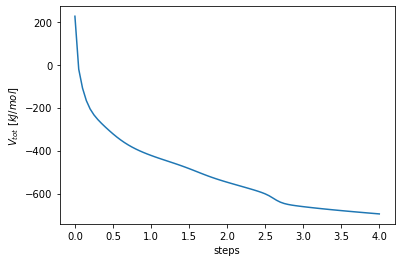

In [34]:
out_emin_system.tre.get_totals().totene.plot(xlabel="steps", ylabel="$V_{tot}~[kJ/mol]$")


The effect seend in the total potential energy can also be observed of course in the peptide molecue coordinats.

In [35]:
view = out_emin_system.trc.view
view

/home/mlehner/anaconda3/envs/pygro2/lib/python3.9/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


NGLWidget(max_frame=80)

Finally we wan to store our energy minimization results as a python pickle obj.

In [36]:
out_emin_system_path = out_emin_system.save(out_emin_system.work_folder+"/emin_vac_result.obj")


In [37]:
#if you want to load the file:
#out_emin_system = Gromos_System.load(out_emin_system.work_folder+"/emin_vac_result.obj")

## Solvatistation and Solvent Energy Minimization

Now you can put the energy minimized penta-peptide in a box of solvent to simulate an aequos environment. This can be done with the *sim_box* function of the gromosSyste, which can solvate the solute in a pre-equilibrated box of solvent molecules. As input for the function *sim_box* you have to specify the following input arguments:
* **periodic_boundary_condition**: the resulting box shape under the argument (r - rectangular, t - truncated octahedron, c - triclinic)
* **in_solvent_cnf_file_path**: the coordinate file of the pre-equilibrated box of solvent molecules under the argument (we are using a template $H_2O$ of the SPC model provided in pygromos.data.solvent_coordinates)
* **minwall**: minimum solute-to-wall distance in $nm$
* **threshold**: the minimum solute-to-solvent distance ins $nm$
* **rotate**: If you are using a rectangular box (@pbc r) it is recommended to use an additional argument. With this additional argument the solute can be rotated (before solvating) such that the largest distance between any two solute atoms is directed along the z-axis, and the largest atom-atom distance in the xy-plane lies in the y-direction. An input file sim box peptide.arg is already prepared. 


In [38]:
help(out_emin_system.sim_box)

Help on function sim_box in module pygromos.gromos.gromosPP:

sim_box(in_solvent_cnf_file_path: str, periodic_boundary_condition: str = 'r', gathering_method: str = None, minwall: float = 0.8, threshold: float = None, rotate: str = None, boxsize: bool = False, _binary_name: str = 'sim_box', verbose: bool = False) -> str
    When simulating a molecule in solution or in a crystal containing solvent
    molecules, the atomic coordinates of the solvent molecules are to be
    generated, if they are not available from experiment. Program sim_box can
    solvate a solute in a pre-equilibrated box of solvent molecules. The file
    specifying the solvent configuration should contain a BOX block with the
    dimensions corresponding to the pre-equilibrated density. The solvent
    topology is read from the solvent block in the specified topology.
    
    Parameters
    ----------
    in_top_path : str
        the path to the input topology file (.top)
    in_cnf_path : str
        the path to

In [39]:
vars(out_emin_system.trc).keys()

dict_keys(['_future_file', '_topology', '_xyz', '_rmsd_traces', '_unitcell_lengths', '_unitcell_angles', '_time_default_to_arange', '_time', '_step', 'TITLE', 'path', '_view'])

### build box system
To put the solvent box around the penta-peptide use following commands:


In [40]:
from pygromos.data.solvent_coordinates import spc

#setup a fresh gromos System:
box_system = out_emin_system.copy()
#box_system = gromos_system.Gromos_System.load(out_emin_system_path) #if you do this step after a break, you could also decide to load the serialized obj from before.

box_system.imd = None
box_system.name = "solvate_box"
box_system.work_folder = bash.make_folder(project_dir+"/c_"+box_system.name)


## set box and solvate the system
box_system.cnf.add_empty_box()
box_system.sim_box(in_solvent_cnf_file_path=spc,
                 periodic_boundary_condition="r",
                 minwall=0.8,
                 threshold=0.23,
                 rotate=False)

#box_system.cnf
box_system.rebase_files() #write out the files (optional) - so you can check them in the folder
box_system.cnf.view #show the results

/home/mlehner/PyGromosTools/pygromos/files/gromos_system/gromos_system.py:1123: UserWarning: did not find the required imd found
  warnings.warn("did not find the required " + file_name + " found")


NGLWidget()

### Add Ions
After solvating the system, two $Cl-$ ions shall be added to the box as counter charges for the two positive peptide residues (Arginine and Lysine).

To add the ions, we need to know the name of the building block in Gromos54A7. We can checkout the names of the Atomtype names in the topology of our system: 

In [41]:
print([ a for a in box_system.top.ATOMTYPENAME])

[['54'], ['O'], ['OM'], ['OA'], ['OE'], ['OW'], ['N'], ['NT'], ['NL'], ['NR'], ['NZ'], ['NE'], ['C'], ['CH0'], ['CH1'], ['CH2'], ['CH3'], ['CH4'], ['CH2r'], ['CR1'], ['HC'], ['H'], ['DUM'], ['S'], ['CU1+'], ['CU2+'], ['FE'], ['ZN2+'], ['MG2+'], ['CA2+'], ['P,SI'], ['AR'], ['F'], ['CL'], ['BR'], ['CMet'], ['OMet'], ['NA+'], ['CL-'], ['CChl'], ['CLChl'], ['HChl'], ['SDmso'], ['CDmso'], ['ODmso'], ['CCl4'], ['CLCl4'], ['FTFE'], ['CTFE'], ['CHTFE'], ['OTFE'], ['CUrea'], ['OUrea'], ['NUrea'], ['CH3p']]


After finding the atomtype name (hint: 'CL-'), we next can use it to add two of these ions to our system with the ion function.

In [42]:
help(box_system.ion)

Help on function ion in module pygromos.gromos.gromosPP:

ion(in_building_block_lib_path: str, in_parameter_lib_path: str, periodic_boundary_condition: str = 'v', negative: list = None, positive: list = None, potential: float = 0.8, mindist: float = 0.8, random_seed: int = None, exclude: str = None, _binary_name: str = 'ion', verbose: bool = False) -> str
    When simulating a charged solute in solution, one may wish to include
    counter-ions in the molecular system in order to obtain a neutral system, or
    a system with a specific ionic strength. The program ion can replace solvent
    molecules by atomic ions by placing the
    ion at the position of the first atom of a solvent molecule. Substitution of
    solvent molecules by positive or negative ions can be performed by selecting
    the solvent positions with the lowest or highest Coulomb potential, respectively,
    or by random selection. In order to prevent two ions being placed too
    close together, a sphere around each

In [43]:
from pygromos.data.solvent_coordinates import spc

## Build directory and setup a fresh Gromos System
ion_system = box_system.copy() 
ion_system.name = "ion"
ion_system.work_folder = bash.make_folder(project_dir+"/d_"+ion_system.name)

#Add the ions to the System
ion_system.ion(negative=[2, "CL-"])


ion_system.rebase_files()   #write out the files, so you can check them (optional)
ion_system.cnf.view  #show the results.

NGLWidget()

### Energy Minimization BOX

In order to relax the unfavorable atom-atom contacts between the solute and the solvent, energy minimization of the solvent should be performed while keeping the solute positionally restrained (i.e. connecting the atom to a reference position by a spring). In order to do that two additional files, in which the positionally restrained atoms and the reference coordinates are specified, have to be generated from the coordinate file in our gromos system. Afterwards, we are going to run the second energy minimization

#### build posistion restraints
To apply position restraints to our simulation for the peptide, we first need to generate a selection of residues, that shall not be modified by the energyminimization. This translates to the residues of the peptide. After this the function generate_posres can be used to generate two files.
* **position restraints - posres(.por)**
    This file defines the selection of atoms, that shall be restrained during the simulation.
* **reference position - refpos (.rpf)**
    This files defines a reference position for the system. Gromos will restrain the selected atoms in the posres file to the reference position file. So if the atom position during the simulation deviates from the refpos file, the program will restrain the atom, such it moves towards the reference position.


In [44]:

from pygromos.simulations.modules.preset_simulation_modules import emin
from pygromos.data.simulation_parameters_templates import template_emin

# Preparing emin gromos system
in_eminBox_system = ion_system.copy()
in_eminBox_system.name = "emin_solvBox"
in_eminBox_system.work_folder = project_dir

# Build position restraints
## Build selection for residues
restrain_res = [k for k in in_eminBox_system.cnf.residues if(not k in ("CL-", "SOLV"))]
print("Selection of residues: ", restrain_res)
## Build the restrain files
in_eminBox_system.generate_posres(residues=restrain_res)

# Check simulation params
in_eminBox_system.imd = template_emin   #Here we use template simulation parameters, The blocks are the same as above in the vacuum case with slight deviations.
in_eminBox_system.imd.INITIALISE.NTISHI = 1

in_eminBox_system.prepare_for_simulation()

in_eminBox_system

Selection of residues:  ['VAL', 'TYR', 'ARG', 'LYSH', 'GLN']



GROMOS SYSTEM: emin_solvBox
################################################################################
WORKDIR: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System
LAST CHECKPOINT: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/emin_vac_result.obj

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/mlehner/PyGromosTools/pygromos/data/simulation_parameters_templates/emin.imd
	top: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/emin_solvBox.top
	cnf: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/emin_solvBox.cnf
	posres: None
	refpos: None
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	['CL6', 'CL7']  resID: [6, 7]  natoms: 2
	Non-LIGANDS:	[]  nmolecules: 0  natoms: 0
	SOLVENT:	SOLV  nmolecules: 930  natoms: 2790



In the ouptut of the in_eminBox_system two new files appeared the posres and refpos file:


In [45]:
print(in_eminBox_system.posres)

TITLE
ion has replaced 2 solvent molecules in /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/d_ion/ion.cnf by
2 negative ions (CL-)
Solvent molecules were selected according to the highest / lowest
electrostatic potential

	>>> Generated with PyGromosTools (riniker group) <<<
END
POSRESSPEC
# 	 
    1 VAL   H1         1   -0.466039509    0.107068229   -0.151069220
    1 VAL   H2         2   -0.401465786    0.026940681   -0.024813902
    1 VAL   N          3   -0.432414924    0.018324392   -0.119519889
    1 VAL   H3         4   -0.505798596   -0.049378313   -0.125221767
    1 VAL   CA         5   -0.318752364   -0.024224333   -0.202467114
    1 VAL   CB         6   -0.373465010   -0.031635286   -0.345171611
    1 VAL   CG1        7   -0.375327181    0.100384420   -0.422508155
    1 VAL   CG2        8   -0.312775396   -0.149655615   -0.421315267
    1 VAL   C          9   -0.202187437    0.069532034   -0.170330753
    1 VAL   O         10   -0.20

In [46]:
in_eminBox_system.refpos 

TITLE
ion has replaced 2 solvent molecules in /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/d_ion/ion.cnf by
2 negative ions (CL-)
Solvent molecules were selected according to the highest / lowest
electrostatic potential

	>>> Generated with PyGromosTools (riniker group) <<<
END
REFPOSITION
# 	 
    1 VAL   H1         1   -0.466039509    0.107068229   -0.151069220
    1 VAL   H2         2   -0.401465786    0.026940681   -0.024813902
    1 VAL   N          3   -0.432414924    0.018324392   -0.119519889
    1 VAL   H3         4   -0.505798596   -0.049378313   -0.125221767
    1 VAL   CA         5   -0.318752364   -0.024224333   -0.202467114
    1 VAL   CB         6   -0.373465010   -0.031635286   -0.345171611
    1 VAL   CG1        7   -0.375327181    0.100384420   -0.422508155
    1 VAL   CG2        8   -0.312775396   -0.149655615   -0.421315267
    1 VAL   C          9   -0.202187437    0.069532034   -0.170330753
    1 VAL   O         10   -0.2

#### Perform Emin
Now we will perform the solvent box energy minimization with the restrained peptide.

In [47]:
# run emin
out_eminBox_system = emin(in_gromos_system=in_eminBox_system, 
                          step_name="e_"+in_eminBox_system.name)



################################################################################

e_emin_solvBox
################################################################################

Script:  /home/mlehner/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  3000
equis:  0
simulation runs:  1


################################################################################

 submit final analysis part 

/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/e_emin_solvBox/ana_out.log
/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/e_emin_solvBox/job_analysis.py


ANA jobID: 0


Whoops what happened here? What you see is the effect of the periodic box and the  peptide placed directly at the corners of the box. 
This is absolutely ok and there is nothing to worry about. We can recenter the peptide and then we see the expected same configuration like from the vacuum emin.

In [48]:
#show resulting coordinates
view = out_eminBox_system.cnf.view
view

NGLWidget()

Now lets fix that!

In [49]:
#out_eminBox_system.cnf.recenter_pbc()

out_eminBox_system.cnf.recreate_view()
recentered_view = out_eminBox_system.cnf.view
recentered_view

NGLWidget()

In [50]:
out_eminBox_system_path = out_eminBox_system.save(out_eminBox_system.work_folder+"/emin_box_result.obj")

## Thermalisation and equilibration.

In the previous steps you have generated a topology and initial coordinates of your system. At this point,
you have to generate initial velocities. In the process of thermalisation and equilibration, initial velocities
are sampled from a Maxwell-Boltzmann distribution at a low temperature and the system is slowly heated
up to the final production simulation temperature. The atoms of the solute are again positionally restrained and
these restraints are loosened while heating up. With the help of these restraints you make sure that the
random initial velocities do not disrupt the initial conformation too much.

### Simulation Paramters
To performe the described equilibration we require additional Simulation Parameter blocks that will be described in the following. First we will load a simulation parameter template for MD simulations.

In [51]:
from pygromos.data.simulation_parameters_templates import template_md_tut as template_md
from pygromos.files.simulation_parameters import imd


md_imd_file = imd.Imd(template_md) #in_eq_system.imd


#### Initialise Block
In the INITIALISE block the NTIVEL tells GROMOS whether it should generate the initial velocities or
read them from the configuration file. NTISHK is used to restore bond length constraints (SHAKE). NTINHT
and NTINHB are only used for Nose-Hoover thermo- and barostats and can be ignored in our case. Every
time an atom is leaving the periodic box and entering it from the opposite site this incident is recorded in
the so-called lattice shift vectors. Using NTISHI we want to make sure that these vectors are initialised to
zero. As you don’t want to use roto-translational constraints NTIRTC can be ignored. NTICOM is used for
initial removal of centre of mass motion. NTISTI is used to reset the stochastic integrals used in stochastic
dynamics (SD) simulations. IG is the random number generator seed and TEMPI the initial temperature used
to generate the Maxwell-Boltzmann distribution for generation of initial velocities. See also 4-94 for more
information.

In [52]:
help(md_imd_file.INITIALISE)

Help on INITIALISE in module pygromos.files.blocks.imd_blocks object:

class INITIALISE(_generic_imd_block)
 |  INITIALISE(NTIVEL: bool = False, NTISHK: int = 0, NTINHT: bool = False, NTINHB: bool = False, NTISHI: bool = False, NTIRTC: bool = False, NTICOM: int = 0, NTISTI: bool = False, IG: int = 0, TEMPI: float = 0, content: List[str] = None)
 |  
 |  INITIALISE block
 |  
 |      This block controls the Initialisation of a simulation.
 |  
 |  Attributes
 |  ----------
 |  NTIVEL: bool
 |      0,1 controls generation of initial velocities
 |      0: read from configuration (default)
 |      1: generate from Maxell distribution at temperature TEMPI
 |  NTISHK: int
 |      0..3 controls shaking of initial configuration
 |      0: no intial SHAKE (default)
 |      1: initial SHAKE on coordinates only
 |      2: initial SHAKE on velocities only
 |      3: initial SHAKE on coordinates and velocities
 |  NTINHT: bool
 |      0,1 controls generation of initial Nose-Hoover chain variables
 

And now we will check the set options in our template:

In [53]:
md_imd_file.INITIALISE

INITIALISE
# 	 NTIVEL 	 NTISHK 	 NTINHT 	 NTINHB
 	 1 	 0 	 0 	 0 	 
# 	 NTISHI 	 NTIRTC 	 NTICOM
 	 1 	 0 	 1 	 
# 	 NTISTI
 	 0 	 
# 	 IG 	 TEMPI
 	 12416 	 300.000000 	 
END

### System Block
In the SYSTEM block you would need to replace NSM with the number of solvent molecules in your system, but the *prepare_simulation* function takes care of that for you. 


In [54]:
#The last SOLV molecule can be found out like this:
str(out_eminBox_system.cnf.POSITION[-1])

'  930 SOLV  HW2     2863    0.186473330    0.337573696    1.044135675\n'

In [55]:
#the template currently contains these values - note NSM is 1172, which is wrong!
md_imd_file.SYSTEM

SYSTEM
# 	 NPM 	 NSM
 	 1 	 5 	 
END

#### STEP Block
In the STEP block you specify how many steps you want to simulate (NSTLIM), at what time your simulation
starts (T) and how big the integration time step (DT) is. In this case you want to start at time 0 and you
want to carry out a 20 ps simulation, because the time unit happens to be ps.

In [56]:
help(md_imd_file.STEP)

Help on STEP in module pygromos.files.blocks.imd_blocks object:

class STEP(_generic_imd_block)
 |  STEP(NSTLIM: int = 0, T: float = 0, DT: float = 0, content: List[str] = None)
 |  
 |  Step Block
 |  
 |      This Block gives the number of simulation steps,
 |  
 |  Attributes
 |  -----------
 |  NSTLIM: int
 |      number of simulations Step till terminating.
 |  T:  float
 |      Starting Time
 |  DT: float
 |      time step [fs]
 |  
 |  Method resolution order:
 |      STEP
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NSTLIM: int = 0, T: float = 0, DT: float = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'DT': <class 'float'>, 'NSTLIM': <class 'int'

In [57]:
md_imd_file.STEP

STEP
# 	 NSTLIM 	 T 	 DT
 	 1000 	 0.000000 	 0.002000 	 
END

#### BOUNDCOND Block
As previously described, with the BOUNDCOND block you specify which PBC you will use. With NTB=1 you
specify rectangular PBC.

In [58]:
help(md_imd_file.BOUNDCOND)

Help on BOUNDCOND in module pygromos.files.blocks.imd_blocks object:

class BOUNDCOND(_generic_imd_block)
 |  BOUNDCOND(NTB: int = 0, NDFMIN: int = 0, content: List[str] = None)
 |  
 |  Boundary Condition Block
 |  
 |      This block describes the boundary condition of the coordinate system.
 |  
 |  Attributes
 |  ----------
 |      NTB : int, optional
 |          Boundary conditions, by default 0
 |          -1 : truncated octahedral
 |           0 : vacuum
 |           1 : rectangular
 |           2 : triclinic
 |      NDFMIN : int, optional
 |          number of degrees of freedom subtracted for temperature, by default 0
 |  
 |  Method resolution order:
 |      BOUNDCOND
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NTB: int = 0, NDFMIN: int = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  -

In [59]:
md_imd_file.BOUNDCOND

BOUNDCOND
# 	 NTB 	 NDFMIN
 	 1 	 3 	 
END

#### MULTIBATH Block

In our case we want to run the simulation at constant temperature. For this purpose, we have to add the
MULTIBATH input block (see 4-96). First we specify which algorithm we will use. In this case we will use
the weak-coupling scheme (ALGORITHM=0). How many temperature baths we want to couple to the system
is specified by NBATHS. You can specify the temperature using the TEMP0 parameter. TAUT is the coupling
time used in the weak-coupling method for this bath. DOFSET specifies the number of distiguishable sets
of degrees of freedom. LAST is pointing to the last atom for the set of degrees of freedom; thus, you put
the number of last atom of your system instead of LSTATM. COMBATH is the temperature bath to which we
want to couple the centre of mass motion of this set of degrees of freedom IRBATH is the temperature bath
to which the internal and rotational degrees of freedom of this set of degrees of freedom are coupled.

In [60]:
help(md_imd_file.MULTIBATH)

Help on MULTIBATH in module pygromos.files.blocks.imd_blocks object:

class MULTIBATH(_generic_imd_block)
 |  MULTIBATH(ALGORITHM: int = 0, NBATHS: int = 0, TEMP0: List[float] = [], TAU: List[float] = [], DOFSET: int = 0, LAST: List[int] = [], COMBATH: List[int] = [], IRBATH: List[int] = [], NUM: int = None, content: List[str] = None)
 |  
 |  MULTIBATH Block
 |  
 |      This block controls the Thermostat of a simulation. Multiple temperature baths can be coupled.
 |  
 |  Attributes
 |  ----------
 |  ALGORITHM:  int
 |      temperature coupling algorithm
 |      weak-coupling(0)
 |      nose-hoover(1)
 |      nose-hoover-chains(2)   num
 |      (where num is the number of chains to use)
 |  NUM: int, optional
 |      Mumber of chains in Nosé Hoover chains scheme [only specify when needed]
 |  NBATHS: int
 |      Number of temperature baths
 |  TEMP0:  List[float]
 |      temperature of each bath (list len == NBATHS)
 |  TAU:    List[float]
 |          coupling of the temperaturebath

In [61]:
md_imd_file.MULTIBATH

MULTIBATH
# ALGORITHM
  0
# NBATHS
  2
# TEMP0(1 ... NBATHS) 	 TAU(1 ... NBATHS)
  300.0 	 0.1
  300.0 	 0.1
# DOFSET
  2
# LAST(1 ... DOFSET) 	 COMBATH(1 ... DOFSET) 	 IRBATH(1 ... DOFSET)
  73 	 1 	 1
  2863 	 2 	 2
END

### COMTRANSROT Block
This block is needed to remove the centre of mass motion (translation and rotation). Without this block it
can happen that all the kinetic energy is converted to centre of mass translation (flying ice cube problem).
With *NSCM* we specify how often the center-of-mass (COM) motion is removed. If *NSCM* is $< 0$ translation
and rotation motion are removed every $|$ *NSCM* $|$ th step. If *NSCM* is $> 0$ only translation motion is removed
every *NSCM*th step.

In [62]:
help(md_imd_file.COMTRANSROT)

Help on COMTRANSROT in module pygromos.files.blocks.imd_blocks object:

class COMTRANSROT(_generic_imd_block)
 |  COMTRANSROT(NSCM: int = 0, content: List[str] = None)
 |  
 |  COMTRANSROT block
 |  
 |  This block controls the center of mass translation and rotation removal. (flying ice cube problem)
 |  
 |  Attributes
 |  ----------
 |  
 |  NSCM : int
 |      controls system centre-of-mass (com) motion removal
 |      0: no com motion removal (default)
 |      < 0: com translation and rotation are removed every abs(NSCM) steps.
 |      > 0: com translation is removed every NSCM steps.
 |  
 |  Method resolution order:
 |      COMTRANSROT
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NSCM: int = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ------------------------------------------------------

In [63]:
md_imd_file.COMTRANSROT

COMTRANSROT
# 	 NSCM
 	 1000 	 
END

### COVALENTFORM Block
This block is needed to define which functional form we will use for bond-stretching (NTBBH), bond-angle
bending (NTBAH) and for torsional dihedral (NTBDN). We just use the default options for all functional forms.

In [64]:
help(md_imd_file.COVALENTFORM)

Help on COVALENTFORM in module pygromos.files.blocks.imd_blocks object:

class COVALENTFORM(_generic_imd_block)
 |  COVALENTFORM(NTBBH: int = 0, NTBAH: int = 0, NTBDN: int = 0, content: List[str] = None)
 |  
 |  COVALENTFORM Block
 |  
 |      The COVALENTFORM Block manages the functional form of the Bonded contributions to the force field.
 |      It is optional in an imd file to define the block.
 |  
 |  Attributes
 |  ----------
 |  NTBBH:  int
 |      0,1 controls bond-stretching potential
 |      0: quartic form (default)
 |      1: harmonic form
 |  NTBAH:  int
 |      0,1 controls bond-angle bending potential
 |      0: cosine-harmonic (default)
 |      1: harmonic
 |  NTBDN:  int
 |      0,1 controls torsional dihedral potential
 |      0: arbitrary phase shifts (default)
 |      1: phase shifts limited to 0 and 180 degrees.
 |  
 |  Method resolution order:
 |      COVALENTFORM
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 | 

In [65]:
md_imd_file.COVALENTFORM

COVALENTFORM
# 	 NTBBH 	 NTBAH 	 NTBDN
 	 0 	 0 	 0 	 
END

### WRITETRAJ Block
Gromos MD simulations produce a massive amount of data and it is impossible to store all the data it produces. The
WRITETRAJ block meets this demand: Here you specify how often the coordinate trajectory (*NTWX*), the
velocity trajectory (*NTWV*), the force trajectory (*NTWF*), the energy trajectory (*NTWE*), the free energy trajectory
(*NTWG*) and the block averaged energy trajectory (*NTWB*) are written out. In the present case, we are only
interested in the coordinates (*NTWX*) and energies (*NTWE*) and we write them every 100th step. The second
switch (*NTWSE*) defines selection criterion for trajectories: if NTWSE = 0 the normal coordinate trajectory will
be written, or if *NTWSE* $> 0$ a minimum energy trajectory will be written.

***

**Warning**: It makes no sense to write out configurations too often. First, it needs a lot of disk space. Second,
the data is highly correlated and so no additional information is gained from it
***

In [66]:
help(md_imd_file.WRITETRAJ)

Help on WRITETRAJ in module pygromos.files.blocks.imd_blocks object:

class WRITETRAJ(_generic_imd_block)
 |  WRITETRAJ(NTWX: int = 0, NTWSE: int = 0, NTWV: int = 0, NTWF: int = 0, NTWE: int = 0, NTWG: int = 0, NTWB: int = 0, content: List[str] = None)
 |  
 |  WRITETRAJ
 |  
 |      The WRITETRAJ Block manages the output frequency of GROMOS. Here you can determine how often a file should be written.
 |  
 |  Attributes
 |  ----------
 |  NTWX:   int
 |      controls writing of coordinate trajectory
 |      0: no coordinate trajectory is written (default)
 |      >0: write solute and solvent coordinates every NTWX steps
 |      <0: write solute coordinates every |NTWX| steps
 |  NTWSE:   int
 |      >= 0 selection criteria for coordinate trajectory writing
 |      0: write normal coordinate trajectory
 |      >0: write minimum-energy coordinate and energy trajectory (based on the
 |      energy entry selected by NTWSE and as blocks of length NTWX)
 |      (see configuration/energy.cc o

In [67]:
md_imd_file.WRITETRAJ

WRITETRAJ
# 	 NTWX 	 NTWSE 	 NTWV 	 NTWF 	 NTWE 	 NTWG 	 NTWB
 	 10 	 0 	 0 	 0 	 10 	 0 	 0 	 
END

### PRINTOUT Block
This block is very similar to the *WRITETRAJ* block but the information about the energies (*NTPR*) is printed
to the output file (.omd). By giving *NTPP*, dihedral angle transitions are written to the special trajectory (.trs).


In [68]:
help(md_imd_file.PRINTOUT)

Help on PRINTOUT in module pygromos.files.blocks.imd_blocks object:

class PRINTOUT(_generic_imd_block)
 |  PRINTOUT(NTPR: int = 0, NTPP: int = 0, content: List[str] = None)
 |  
 |  PRINTOUT block
 |  
 |      This Block manages the output frequency into the .omd/std-out file.
 |  
 |  Attributes
 |  ----------
 |  NTPR: int
 |      print out energies, etc. every NTPR steps
 |  NTPP: int
 |      =1 perform dihedral angle transition monitoring
 |  
 |  Method resolution order:
 |      PRINTOUT
 |      _generic_imd_block
 |      pygromos.files.blocks._general_blocks._generic_gromos_block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, NTPR: int = 0, NTPP: int = 0, content: List[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'NTPP': <class 'int'>, 'NTPR': <class 'int'>, '

In [69]:
md_imd_file.PRINTOUT

PRINTOUT
# 	 NTPR 	 NTPP
 	 250 	 0 	 
END

### PAIRLIST Block
MD++ knows different algorithms for the generation of the pairlist, a list containing the atoms interacting
with each other. Here, we use a grid based pairlist generation: 
the space is discretized into grid cells and only the neighboring cells are searched for interacting partners. 
The use of this algorithm results in a
The pairlist is generated every 5th (*NSNB*) step. 
*RCUTP* and *RCUTL* are the cutoffs for the pairlist construction for the short-range and the long-range interactions.
The pairlist is generated every 5th (*NSNB*) step. *RCUTP* and *RCUTL* are the cutoffs for the pairlist construction for
the short-range and the long-range interactions.

In [70]:
help(md_imd_file.PAIRLIST)

Help on PAIRLIST in module pygromos.files.blocks.imd_blocks object:

class PAIRLIST(_generic_imd_block)
 |  PAIRLIST(ALGORITHM: int = 0, NSNB: int = 0, RCUTP: float = 0, RCUTL: float = 0, SIZE: Union[str, float] = 0, TYPE: Union[str, bool] = False, content: List[str] = None)
 |  
 |  PAIRLIST Block
 |  
 |          This block is controlling the pairlist control.
 |  
 |  Attributes
 |  ----------
 |  ALGORITHM: int
 |      standard(0) (gromos96 like pairlist)
 |      grid(1) (md++ grid pairlist)
 |      grid_cell(2) (creates a mask)
 |  NSNB:   int
 |      frequency (number of steps) a pairlist is constructed
 |  RCUTPL: float
 |      short-range cut-off in twin-range
 |  RCUTL:  float
 |      intermediate-range cut-off in twin-range
 |  SIZE:   str, float
 |      grid cell size (or auto = 0.5 * RCUTP)
 |  TYPE:   str, bool
 |      chargegoup(0) (chargegroup based cutoff)
 |      atomic(1)     (atom based cutoff)
 |  
 |  Method resolution order:
 |      PAIRLIST
 |      _generic_imd_b

In [71]:
md_imd_file.PAIRLIST

PAIRLIST
# 	 ALGORITHM 	 NSNB 	 RCUTP 	 RCUTL 	 SIZE 	 TYPE
 	 1 	 5 	 0.800000 	 1.400000 	 0.4 	 0 	 
END

### POSITIONRES Block
Finally, we want to restrain the position of our solute. The restraining is achieved by a harmonic special
force term with a force constant of *CPOR*.

In [72]:
from pygromos.files.blocks.imd_blocks import POSITIONRES

help(POSITIONRES)

Help on class POSITIONRES in module pygromos.files.blocks.imd_blocks:

class POSITIONRES(_generic_imd_block)
 |  POSITIONRES(NTPOR: int = 0, NTPORB: int = 0, NTPORS: int = 0, CPOR: int = 0, content: List[str] = None)
 |  
 |  POSITIONRES block
 |  
 |      This block allows the managment of the Position Restraints during the Simulation.
 |  
 |  Attributes
 |  ----------
 |  NTPOR:
 |      0..3 controls atom positions re(con)straining.
 |      0: no position re(con)straints (default)
 |      1: restraining with force constant CPOR
 |      2: restraining with force constant CPOR weighted by atomic B-factors
 |      3: constraining
 |  NTPORB:
 |      0,1 controls reading of reference positions and B-factors
 |      0: read reference positions from startup file.
 |      1: read reference positions and B-factors from special file
 |  NTPORS:
 |      0,1 controls scaling of reference positions upon pressure scaling
 |      0: do not scale reference positions
 |      1: scale reference posi

In [73]:
md_imd_file.add_block(block=POSITIONRES(NTPOR=1, NTPORB=1, CPOR=25000))

md_imd_file.POSITIONRES

POSITIONRES
# 	 NTPOR 	 NTPORB 	 NTPORS 	 CPOR
 	 1 	 1 	 0 	 25000 	 
END

Now you should know the main blocks of the Gromos input files.


### Perform Thermalisation
Next we will run multiple simulations, which will slowly heat up the simulation system. This can easily be done by modifying parameters on the run. First we will setup a gromos system and prepare it. Next we will perform the simulations.

***
**Warning**: Depending on your system’s speed this will take up to five hours. As we are using the simulation
directory as the working directory there will be an error message after every job which can be ignored.
***

***
 *Hint* : Have a look at all the output files eq peptide *.omd. If anything goes wrong, a message will be
printed to the output file.
***

In [74]:
from pygromos.simulations.modules.preset_simulation_modules import md

## Preparing emin gromos system
in_eq_system = out_eminBox_system.copy()
in_eq_system.name = "eq_thermalisation"
in_eq_system.work_folder = project_dir

### Build position restraints
restrain_res = [k for k in in_eq_system.cnf.residues if(not k in ("CL-", "SOLV"))]
in_eq_system.generate_posres(residues=restrain_res)

### Check simulation params
in_eq_system.imd = md_imd_file

### Set simulation lengths: 
in_eq_system.imd.STEP.NSTLIM = 1000 # each temperature will do 1000 steps, this might take some time!

in_eq_system.prepare_for_simulation(not_ligand_residues=["CL-"])
sys_same = in_eq_system.name

in_eq_system


GROMOS SYSTEM: eq_thermalisation
################################################################################
WORKDIR: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System
LAST CHECKPOINT: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/emin_box_result.obj

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/mlehner/PyGromosTools/pygromos/data/simulation_parameters_templates/md_tut.imd
	top: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/eq_thermalisation.top
	cnf: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/eq_thermalisation.cnf
	posres: None
	refpos: None
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 5 natoms: 71
	LIGANDS:	[]  resID: []  natoms: 0
	Non-LIGANDS:	['CL-']  nmolecules: 0  natoms: 2
	SOLVENT:	SOLV  nmolecules: 930  natoms: 2790



After preparing the system we can now start simulating.

In [75]:
## run Thermalisation.
from pygromos.simulations.modules.preset_simulation_modules import simulation

temperatures = [60, 120, 180, 240, 300] #the temperatures we want to simulate.

print("Heating upt to: ", end="\t")
for runID, temperature in enumerate(temperatures):
    print(temperature, end="\t")
    
    #adapt temperature
    in_eq_system.imd.MULTIBATH.TEMP0 = [temperature for x in range(in_eq_system.imd.MULTIBATH.NBATHS)]

    #turn off the posres for the last run.
    if(runID+1 == len(temperatures)): #Last Run
        in_eq_system.imd.POSITIONRES.NTPOR = 0
        in_eq_system.imd.POSITIONRES.CPOR = 0

        out_eq_system = simulation(in_gromos_simulation_system=in_eq_system,
                                   step_name="f_"+sys_same,
                                   simulation_runs=runID+1)
        break
    else:
        out_eq_system = simulation(in_gromos_simulation_system=in_eq_system,
                                   step_name="f_"+sys_same,
                                   simulation_runs=runID+1,
                                   analysis_script=None,
                                   verbose=False)
    
    in_eq_system = out_eq_system

    
print("done")

Heating upt to: 	60	

120	

180	

240	

300	

################################################################################

f_eq_thermalisation
################################################################################

Script:  /home/mlehner/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  1000
equis:  0
simulation runs:  5


################################################################################

 submit final analysis part 

/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/f_eq_thermalisation/ana_out.log
/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/f_eq_thermalisation/job_analysis.py


ANA jobID: 0
done


In [76]:
#This took some time, so lets store it! So we can use it later again.
out_eq_therm_system_path = out_eq_system.save(out_eq_system.work_folder+"/eq_therm_result2.obj")


### Analysis of Thermalisation:
Next we want to check the results of our Thermalisation. We will have a look at the coordinate trajectory and the temperatures of the system.

#### Check the coordinate traj
First we will check the trajectory of the termalisation. Again we first need to shift the coordinates, so we can se the fully connected peptide.

In [77]:
coordinate_traj = out_eq_system.trc
coordinate_traj.image_molecules()
view = coordinate_traj.view
view

NGLWidget(max_frame=499)

#### Check the temperature
After this, we would like to see the temperature development. 
First lets collect all temperature calculations from the simulation:

In [78]:
energy_traj = out_eq_system.tre
temperatures= energy_traj.get_temperature()
temperatures

,bath1,bath2
time,,
0.00,339.434523,378.651407
0.02,140.118831,389.835477
0.04,160.978927,383.542770
0.06,202.329896,379.484185
0.08,151.866737,349.959059
...,...,...
9.90,335.579171,309.355612
9.92,275.800192,310.621616
9.94,265.092556,307.698791


Next we want to visualize the data to get an impresstionof what happened. 
Can you see how the Temperature was constantly raised per simulation and started to equilibrate forming plateus?

Text(0.5, 0, '$t~[ps]$')

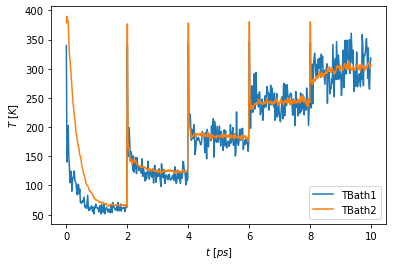

In [79]:
from matplotlib import pyplot as plt

plt.plot(temperatures.bath1, label="TBath1")
plt.plot(temperatures.bath2, label="TBath2")

plt.legend()
plt.ylabel("$T~[K]$")
plt.xlabel("$t~[ps]$")

## Molecular dynamics sampling simulation.
The equilibration period already produced a short simulation at constant temperature and volume. At
this point we want to elongate the simulation to a nanosecond under constant temperature and pressure.

### Simulation Paramters
First, we don’t use position restraining anymore and so, the POSITIONRES block in the next step.
Next we want to simulate under constant pressure rather than constant volume (NVT-> NPT). For this purpose we have to add
an additional block:



In [80]:
from pygromos.data.simulation_parameters_templates import template_md_tut as template_md
from pygromos.files.simulation_parameters.imd import Imd

imd_file = Imd(template_md)

help(imd_file.PRESSURESCALE)

Help on PRESSURESCALE in module pygromos.files.blocks.imd_blocks object:

class PRESSURESCALE(_generic_imd_block)
 |  PRESSURESCALE(COUPLE: int = 0, SCALE: int = 0, COMP: float = 0, TAUP: float = 0, VIRIAL: int = 0, SEMIANISOTROPIC: List[int] = [], PRES0: List[List[float]] = [[0, 0, 0], [0, 0, 0], [0, 0, 0]], content: List[str] = None)
 |  
 |  PRESSURESCALE Block
 |  This block controls the barostat of the simulation
 |  
 |  Attributes
 |  -----------
 |  COUPLE: int
 |      off(0), calc(1), scale(2)
 |  SCALE:  int
 |      off(0), iso(1), aniso(2), full(3), semianiso(4)
 |  COMP:   float
 |      compessibility
 |  TAUP:   float
 |      coupling strength
 |  VIRIAL: int
 |      none(0), atomic(1), group(2)
 |  SEMIANISOTROPIC:    List[int]
 |      (semianisotropic couplings: X, Y, Z)
 |      e.g. 1 1 2: x and y jointly coupled and z separately coupled
 |      e.g. 0 0 1: constant area (xy-plane) and z coupled to a bath
 |  PRES0:  List[List[float]]
 |      reference pressure
 |  
 | 

In the PRESSURESCALE block we tell Gromos to calculate and scale the pressure by setting *COUPLE* to $2$. As
the box should be isotropically scaled we set *SCALE* equal to $1$. The weak-coupling method (Sec. 2-12.2.2)
uses two additional parameters: *COMP* is the isothermal compressibility and *TAUP* is the coupling time. We
are calculating the molecular virial (*VIRIAL* is equal to $2$), so intramolecular forces don’t contribute to the
pressure. The next line is only used for semi-anisotropic pressure coupling and can be ignored in our case.
Finally, we have to specify the reference pressure in a tensor form


In [81]:
imd_file.PRESSURESCALE

PRESSURESCALE
# 	 COUPLE 	 SCALE 	 COMP 	 TAUP 	 VIRIAL
 	 2 	 1 	 0.000458 	 0.500000 	 2 	 
# 	 SEMIANISOTROPIC COUPLINGS(X, Y, Z)
 	 1 	 1 	 1 	 
# 	 PRES0(1...3,1...3)
 	 0.06102 	 0.0 	 0.0
 	 0.0 	 0.06102 	 0.0
 	 0.0 	 0.0 	 0.06102 	 
END

### Perform MD - Production
In the other blocks only minor things have changed: the temperature was set to 300K and the trajectories
are written out less often (every 250th step only). Next we are going to set up the Gromos System. We will remove the position restraints and the old trajectories.

In [82]:
from pygromos.simulations.modules.preset_simulation_modules import md

in_md_system = out_eq_system.copy()

in_md_system.work_folder = project_dir
in_md_system.name = "md"

### Check simulation params
in_md_system.imd = imd_file 

## imd parameters
in_md_system.imd.STEP.NSTLIM = 1000
in_md_system.imd.WRITETRAJ.NTWX = 10
in_md_system.imd.WRITETRAJ.NTWE = 10
in_md_system.imd.INITIALISE.NTIVEL = 0

in_md_system.prepare_for_simulation()

in_md_system


GROMOS SYSTEM: md
################################################################################
WORKDIR: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System
LAST CHECKPOINT: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/eq_therm_result2.obj

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/mlehner/PyGromosTools/pygromos/data/simulation_parameters_templates/md_tut.imd
	top: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/f_eq_thermalisation.top
	cnf: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/f_eq_thermalisation.cnf
	posres: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/f_eq_thermalisation.pos
	refpos: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/f_eq_thermalisation.rpf
FUTURE PROMISE: False
SYSTEM: 
	PROTEIN:	protein  nresidues: 

In [83]:
out_md_system = md(in_gromos_system=in_md_system,
                   step_name="g_"+in_md_system.name,
                   simulation_runs=3)
out_md_system

################################################################################

g_md
################################################################################

Script:  /home/mlehner/PyGromosTools/pygromos/simulations/hpc_queuing/job_scheduling/schedulers/simulation_scheduler.py

################################################################################
Simulation Setup:
################################################################################

steps_per_run:  1000
equis:  0
simulation runs:  3


################################################################################

 submit final analysis part 

/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/ana_out.log
/home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/job_analysis.py


ANA jobID: 0



GROMOS SYSTEM: g_md
################################################################################
WORKDIR: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System
LAST CHECKPOINT: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/eq_therm_result2.obj

GromosXX_bin: None
GromosPP_bin: None
FILES: 
	imd: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/input/g_md.imd
	top: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/input/g_md.top
	cnf: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/analysis/data/g_md.cnf
	posres: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/input/g_md.pos
	refpos: /home/mlehner/PyGromosTools/docs/sphinx_project/Tutorials/example_files/Tutorial_System/g_md/input/g_md.rpf
FUTURE PROMISE: True
SYSTEM: 
	PROTEIN:	prot

In [84]:
out_md_system_path = out_md_system.save(out_md_system.work_folder+"/md_result.obj")


After all the jobs are finished, you should start to analyse the trajectories.


### Analysis

#### First Look Analysis
Let's first have a look on the final coordinates.

In [85]:
out_md_system.cnf.shift_periodic_boundary()
out_md_system.cnf.recenter_pbc()
out_md_system.cnf.recreate_view()
out_md_system.cnf.view

NGLWidget()

In [86]:
coordinate_traj = out_md_system.trc

coordinate_traj.image_molecules()
coordinate_traj.recreate_view()
view = coordinate_traj.view
view

/home/mlehner/anaconda3/envs/pygro2/lib/python3.9/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


NGLWidget(max_frame=299)


#### Energy Analysis
The program calculates the average of the specified properties as well as the root-mean-square deviations
(rmsd) and a statistical error estimate (error est.). The error estimate is calculated from block averages
of growing sizes extrapolating to infinite block size1

***
**Warning:** Sometimes the error estimates are NaN (not a number), which is due to the fact that we do not
have enough values to calculate a meaningful error estimate.
***

In [87]:
energy_traj = out_md_system.tre
total_energies = energy_traj.get_totals()
total_energies

,totene,totkin,totpot,totcov,totbond,totangle,totimproper,totdihedral,totcrossdihedral,totnonbonded,...,eds_vmix,eds_vr,eds_emax,eds_emin,eds_globmin,eds_globminfluc,entropy,totqm,totbsleus,totrdc
time,,,,,,,,,,,,,,,,,,,,,
0.00,-47298.79052,1618.643530,-48917.43405,252.617847,0.0,120.249867,38.645933,93.722048,0.0,-49170.05190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.02,-46269.03164,2464.331707,-48733.36335,221.036528,0.0,89.627692,45.038378,86.370457,0.0,-48954.39987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.04,-45353.28866,3010.497757,-48363.78641,279.233662,0.0,123.663886,51.890773,103.679003,0.0,-48643.02008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.06,-44504.63121,3341.937138,-47846.56835,292.535309,0.0,139.711508,45.975944,106.847857,0.0,-48139.10366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.08,-43753.16520,3684.261609,-47437.42681,288.216128,0.0,129.742936,56.731466,101.741727,0.0,-47725.64294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.90,-33587.58374,7335.329137,-40922.91288,229.219891,0.0,115.319382,49.971611,63.928898,0.0,-41152.13277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.92,-33587.32408,7184.037953,-40771.36203,224.153707,0.0,90.114185,48.815956,85.223565,0.0,-40995.51574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.94,-33542.19033,7240.118961,-40782.30929,209.515148,0.0,100.347480,44.342135,64.825533,0.0,-40991.82444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Simulation Data'}, xlabel='t [ps]', ylabel='V [kJ/mol]'>

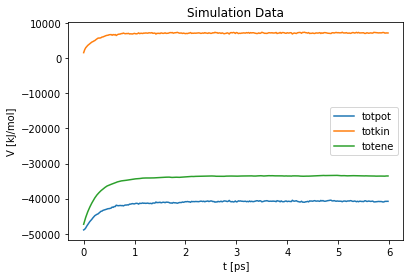

In [88]:
#Next we plot some data of the energies to se their development.

time_axis = energy_traj.time
total_energies.totpot.plot(legend=True)
total_energies.totkin.plot(legend=True)
total_energies.totene.plot(xlabel="t [ps]", ylabel="V [kJ/mol]", title="Simulation Data", legend=True)


In the Following we want to see the different contributions of the molecules with their VdW and Culomb interaxtions.
 we add up the van der Waals and Coulomb energies of the peptide-peptide interactions.

Now we want to look at two variables:
* peptide_water_nonbonded
* peptide_Cl_nonbonded

The information about the nonbondeds can be retrieved from the ForceGroup Nonbonded contributions.
If you check the used imd file, you reckognize three Force groups in the FORCEGROUP block. These are limited by the last atom of the group and you can check the group atoms in the topology or coordinate file. 
They should correspond here to:
1. Peptide
2. 2 Cl- ions
3. Water molecules

The interactions of these forcegroups are stored in the following pattern, which can be adapted to any force group number (PseudoCode: for i in range(1+nFroceGroups) for j in range(i, nFroceGroups)):

1. ForceGroup - 1. ForceGroup: intra force group nonbondeds (peptide - peptide)
1. ForceGroup - 2. ForceGroup: inter force group nonbondeds between force group 1 and 2 (peptide - Cl-)
1. ForceGroup - 3. ForceGroup: inter force group nonbondeds between force group 1 and 3 (peptide - Water)
2. ForceGroup - 2. ForceGroup: intra force group nonbondeds (Cl- - Cl-)
3. ForceGroup - 3. ForceGroup: inter force group nonbondeds between force group 2 and 3 (Cl- - Water)
4. ForceGroup - 3. ForceGroup: intra force group nonbondeds (Water - Water)

In [89]:
#First lets get the Force Group Energy contributions:
forceGroupNonbondedContributions = energy_traj.get_nonbondedContributions()

#Here we give each Force Group contribution category nice names:
peptide_peptide_nonbonded = forceGroupNonbondedContributions[1][1]
peptide_Cl_nonbonded = forceGroupNonbondedContributions[1][2]
peptide_water_nonbonded = forceGroupNonbondedContributions[1][3]

Cl_Cl_nonbonded = forceGroupNonbondedContributions[2][2]
Cl_water_nonbonded = forceGroupNonbondedContributions[2][3]

water_water_nonbonded = forceGroupNonbondedContributions[3][3]

array([<AxesSubplot:xlabel='writeOuts', ylabel='V [kJ/mol]'>,
       <AxesSubplot:xlabel='writeOuts', ylabel='V [kJ/mol]'>,
       <AxesSubplot:xlabel='writeOuts', ylabel='V [kJ/mol]'>,
       <AxesSubplot:xlabel='writeOuts', ylabel='V [kJ/mol]'>],
      dtype=object)

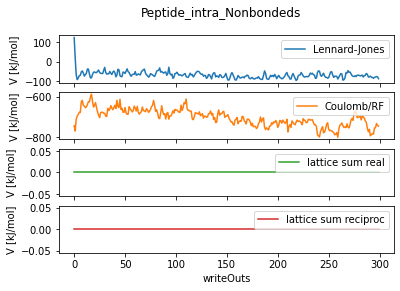

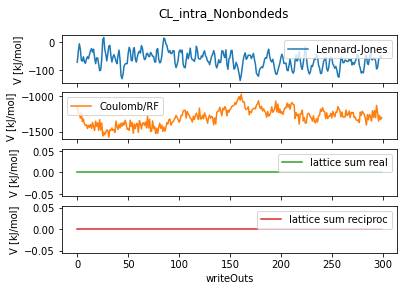

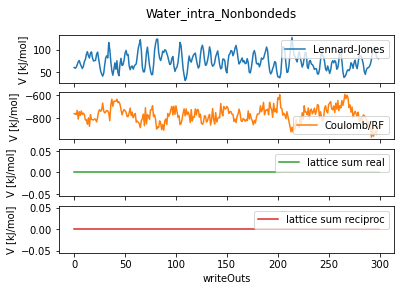

In [90]:
#Here we look at the different Nonbonded contributions of each 
peptide_peptide_nonbonded.plot(title="Peptide_intra_Nonbondeds", ylabel="V [kJ/mol]", xlabel="writeOuts", subplots=True)
Cl_Cl_nonbonded.plot(title="CL_intra_Nonbondeds", ylabel="V [kJ/mol]", xlabel="writeOuts", subplots=True)
water_water_nonbonded.plot(title="Water_intra_Nonbondeds", ylabel="V [kJ/mol]", xlabel="writeOuts", subplots=True)

<AxesSubplot:title={'center':'Peptide Nonbondeds'}, xlabel='writeOuts', ylabel='V [kJ/mol]'>

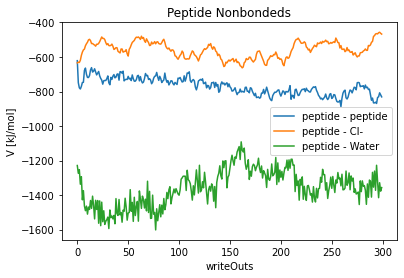

In [91]:
#Next we calculate the sum of all contributions
#The sum over the axis 1 sums up all contribution types for a timestep t.
peptide_peptide_nonbonded.sum(axis=1).plot(label="peptide - peptide", legend=True)
peptide_Cl_nonbonded.sum(axis=1).plot(label="peptide - Cl-", legend=True)
peptide_water_nonbonded.sum(axis=1).plot(label="peptide - Water", ylabel="V [kJ/mol]", xlabel="writeOuts", title="Peptide Nonbondeds", legend=True)

<AxesSubplot:title={'center':'Total Nonbonded Contributions of peptide'}, xlabel='steps', ylabel='V [kJ/mol]'>

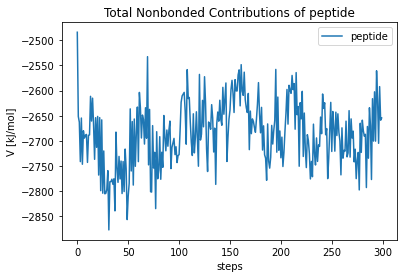

In [92]:
# Here we look at the total nonbonded Contributions of the peptide 
peptide_nonbonded = peptide_peptide_nonbonded+peptide_Cl_nonbonded+peptide_water_nonbonded
#The sum over the axis 1 sums up all contribution types for a timestep t.
peptide_nonbonded.sum(axis=1).plot( label="peptide", ylabel="V [kJ/mol]", xlabel="steps", title="Total Nonbonded Contributions of peptide", legend=True)


#### Coordinate Analysis
In the next step, we want to have a look at the coordinates of our simulation.
first we will dcalculate the rmsd, second we will analyse the distance of the CL- to the positive charged atoms in the peptide. 



***
**Warning**: Under Development ;)
***

In [93]:
final_coordinate = out_md_system.cnf
coordinate_traj = out_md_system.trc


<AxesSubplot:xlabel='t [ps]', ylabel='RMSD'>

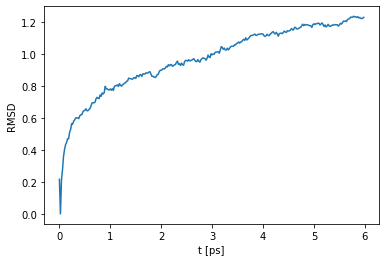

In [94]:
coordinate_traj.rmsd(1).sum(axis=1).plot(ylabel="RMSD", xlabel="t [ps]")

#### Distance CL- to the peptide

#

In [95]:
print("CL- atoms:", [(ap.atomType, ap.atomID) for ap in final_coordinate.POSITION if(ap.resName == "CL-")])
print("ARG atoms:", [(ap.atomType, ap.atomID) for ap in final_coordinate.POSITION if(ap.resName == "ARG")])
print("LYSH atoms:", [(ap.atomType, ap.atomID) for ap in final_coordinate.POSITION if(ap.resName == "LYSH")])
print("NTERM atoms:", [(ap.atomType, ap.atomID) for ap in final_coordinate.POSITION if(ap.resName == "VAL")])

CL- atoms: [('CL', 72), ('CL', 73)]
ARG atoms: [('N', 29), ('H', 30), ('CA', 31), ('CB', 32), ('CG', 33), ('CD', 34), ('NE', 35), ('HE', 36), ('CZ', 37), ('NH1', 38), ('HH11', 39), ('HH12', 40), ('NH2', 41), ('HH21', 42), ('HH22', 43), ('C', 44), ('O', 45)]
LYSH atoms: [('N', 46), ('H', 47), ('CA', 48), ('CB', 49), ('CG', 50), ('CD', 51), ('CE', 52), ('NZ', 53), ('HZ1', 54), ('HZ2', 55), ('HZ3', 56), ('C', 57), ('O', 58)]
NTERM atoms: [('H1', 1), ('H2', 2), ('N', 3), ('H3', 4), ('CA', 5), ('CB', 6), ('CG1', 7), ('CG2', 8), ('C', 9), ('O', 10)]


Calculate the distances now to the different CL- ions.

<AxesSubplot:xlabel='t [ps]', ylabel='r [nm]'>

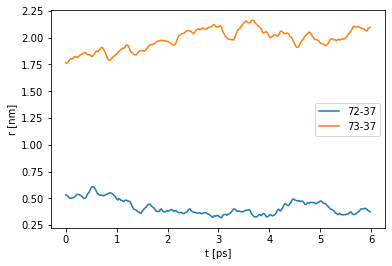

In [96]:
coordinate_traj.distances(atom_pairs=[[72, 37], [73, 37]]).plot(label="CL-1/2 - ARG-CZ", legend=True, xlabel="t [ps]", ylabel="r [nm]")

<AxesSubplot:xlabel='t [ps]', ylabel='r [nm]'>

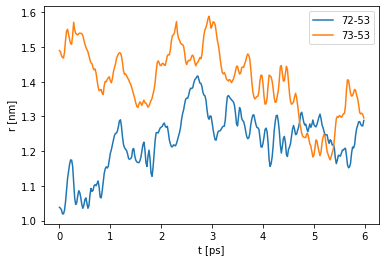

In [97]:
coordinate_traj.distances(atom_pairs=[[72, 53], [73, 53]]).plot(label="CL-1/2 - LYSH-NZ", legend=True, xlabel="t [ps]", ylabel="r [nm]")

<AxesSubplot:xlabel='t [ps]', ylabel='r [nm]'>

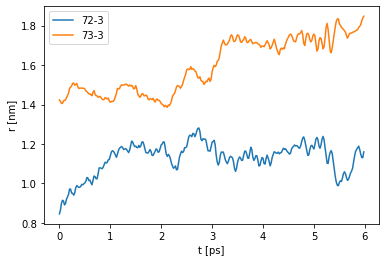

In [98]:
coordinate_traj.distances(atom_pairs=[[72, 3], [73, 3]]).plot(label="CL-1/2 - N-TERM", legend=True, xlabel="t [ps]", ylabel="r [nm]")